In [3]:

import os

from collections import defaultdict


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from PIL import Image

from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
)

from CLIP.clip import clip



In [4]:
from prompts.global_prompts import promts as p


to_select=['bocanegra','cazon','cerdo_marino','musola','pintarroja','santiaguesa','tembladera']

colective="Our_Name"
ruta_salida = 'prompts_general.py'
dict_t="Our Name"

exclude_classes = []

base_p = [{'bocanegra':p['bocanegra']}, {'cazon':p['cazon']},{'cerdo_marino':p['cerdo marino']},{'musola':p['musola']},{'pintarroja':p['pintarroja']},{'santiaguesa':p['santiaguesa']},{'tembladera':p['tembladera']}]

In [5]:
data = [
    ['bocanegra','galeus melastomus','blackmouth catshark','carcharhiniformes','scyliorhinidae','shark'],
    ['cazon','galeorhinus galeus','tope shark','carcharhiniformes','triakidae','shark'],
    ['cerdo_marino','oxynotus centrina','angular roughshark','squaliformes','oxynotidae','shark'],
    ['musola','mustelus mustelus','smouth-hound','carcharhiniformes','triakidae','shark'],
    ['pintarroja','scyliorhinus canicula','small-spotted catshark','carcharhiniformes','scyliorhinidae','shark'],
    ['santiaguesa','raja undulata','undulate ray','rajiformes','rajidae','stringray'],
    ['tembladera','torpedo marmorata','spotted torpedo','torpediniformes','torpedinidae','stringray'],
]

df = pd.DataFrame(data, columns=['Our Name','Scientific Name', 'Common Name', 'Order', 'Family','Animal']) 
df

,Our Name,Scientific Name,Common Name,Order,Family,Animal
0,bocanegra,galeus melastomus,blackmouth catshark,carcharhiniformes,scyliorhinidae,shark
1,cazon,galeorhinus galeus,tope shark,carcharhiniformes,triakidae,shark
2,cerdo_marino,oxynotus centrina,angular roughshark,squaliformes,oxynotidae,shark
3,musola,mustelus mustelus,smouth-hound,carcharhiniformes,triakidae,shark
4,pintarroja,scyliorhinus canicula,small-spotted catshark,carcharhiniformes,scyliorhinidae,shark
5,santiaguesa,raja undulata,undulate ray,rajiformes,rajidae,stringray
6,tembladera,torpedo marmorata,spotted torpedo,torpediniformes,torpedinidae,stringray


In [6]:
main_folder = r'D:\datasets\ELASMOBRANC\A_SISTEMATICAS'

esquema_paths_shark = []
esquema_labels_shark = []
nombres_archivos=[]

for class_name in os.listdir(main_folder):
    if any(excl in class_name.lower() for excl in exclude_classes):
        continue  

    class_folder = os.path.join(main_folder, class_name)
    print(class_folder)

    if os.path.isdir(class_folder):
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            if os.path.isfile(img_path):
                esquema_paths_shark.append(img_path)
                esquema_labels_shark.append(class_name)
                nombres_archivos.append(img_name)



D:\datasets\ELASMOBRANC\A_SISTEMATICAS\bocanegra
D:\datasets\ELASMOBRANC\A_SISTEMATICAS\cazon
D:\datasets\ELASMOBRANC\A_SISTEMATICAS\cerdo_marino
D:\datasets\ELASMOBRANC\A_SISTEMATICAS\musola
D:\datasets\ELASMOBRANC\A_SISTEMATICAS\pintarroja
D:\datasets\ELASMOBRANC\A_SISTEMATICAS\santiaguesa
D:\datasets\ELASMOBRANC\A_SISTEMATICAS\tembladera


In [7]:
name_to_family = dict(zip(df['Our Name'], df[dict_t]))
esquema_labels_shark = [name_to_family[name] for name in esquema_labels_shark]
print(esquema_labels_shark)

['bocanegra', 'bocanegra', 'bocanegra', 'cazon', 'cazon', 'cazon', 'cerdo_marino', 'cerdo_marino', 'cerdo_marino', 'musola', 'musola', 'musola', 'pintarroja', 'pintarroja', 'pintarroja', 'santiaguesa', 'santiaguesa', 'santiaguesa', 'tembladera', 'tembladera', 'tembladera']


In [8]:
posiciones_labels = defaultdict(list)

for idx, label in enumerate(esquema_labels_shark):
    posiciones_labels[label].append(idx)

In [9]:
longitud_total = len(esquema_labels_shark)
binary_tensors = {}

for label, posiciones in posiciones_labels.items():
    vector_binario = [False] * longitud_total
    for pos in posiciones:
        vector_binario[pos] = True
    binary_tensors[label] = torch.tensor(vector_binario, dtype=torch.bool)

for label in sorted(binary_tensors):
    print(f"{label}: {binary_tensors[label]}")


bocanegra: tensor([ True,  True,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False])
cazon: tensor([False, False, False,  True,  True,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False])
cerdo_marino: tensor([False, False, False, False, False, False,  True,  True,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False])
musola: tensor([False, False, False, False, False, False, False, False, False,  True,
         True,  True, False, False, False, False, False, False, False, False,
        False])
pintarroja: tensor([False, False, False, False, False, False, False, False, False, False,
        False, False,  True,  True,  True, False, False, False, False, False,
        False])
santiaguesa: tensor([False, False, False, False, False, False, False, False, False, Fals

In [10]:
def sigmoid_weighted_mean(tensor: torch.Tensor,k) -> torch.Tensor:
    k = k
    weights = 1 / (1 + torch.exp(k * tensor))
    weights = weights / weights.sum(dim=0, keepdim=True)
    weighted_mean = (weights * tensor).sum(dim=0)
    return weighted_mean 

def compute_similarity_values(
    i, idx, pt, species, binary_tensors, feature_mean, feat_texts, val_revise):

    zn_neg_list = []
    for bi in binary_tensors:
        if bi != species:    
            feature_neg = feature_mean[bi]
            similarity_neg = 100 * feature_neg @ feat_texts[i][idx].T
            zn_neg_list.append(similarity_neg)

    zn = torch.stack(zn_neg_list)
    zp = 100 * feature_mean[species] @ feat_texts[i][idx].T
    col_values = [x[pt] for x in val_revise]

    return zn, zp, col_values

def insert_diagonal_infs(tensor_list):
    new_tensors = []
    for i, t in enumerate(tensor_list):
        n = t.size(0)
        new_t = torch.empty(n + 1, dtype=t.dtype, device=t.device)
        new_t[:i] = t[:i]
        new_t[i] = float('-inf')
        new_t[i+1:] = t[i:]
        new_tensors.append(new_t)
    return new_tensors

In [11]:
for clave, lista in zip(to_select, base_p):
    classes_description = lista[clave]  
    print(classes_description)


[['Shark with a long low anal fin, narrow caudal fin with a crest of teeth, slender body, gray to reddish brown coloration with oval spots encircled by white rings', 'Shark slender-bodied, bearing a long low anal fin, narrow caudal with tooth-like crest, gray-brown to reddish tone with oval markings bordered in white', 'Shark with elongated slim body, anal fin long and low, caudal fin narrow with crest, gray to brownish red color patterned with oval spots circled in white', 'Shark featuring a narrow elongated body, long low anal fin, caudal with a crest of denticles, gray to reddish brown shade with oval white-ringed spots', 'Shark with slender body, narrow caudal fin carrying a crest of teeth, long low anal fin, gray-brown coloration with oval markings outlined in white', 'Shark slim figure, anal fin extended low, caudal fin narrow and ridged with teeth, gray to reddish brown tone, oval spots rimmed in white', 'Shark elongated and slender, long low anal fin, caudal fin narrow with den

In [12]:
from PIL import Image

def resize_con_padding(img, target_size=(224, 224), fill_color=(255, 255, 255)):
    """
    Reescala la imagen manteniendo el aspecto y la centra en un lienzo cuadrado con padding.
    
    Args:
        img: PIL.Image
        target_size: tamaño final (ancho, alto)
        fill_color: color del fondo (por defecto blanco)
    
    Returns:
        PIL.Image redimensionada sin distorsión
    """
    img_ratio = img.width / img.height
    target_ratio = target_size[0] / target_size[1]

    if img_ratio > target_ratio:
        new_width = target_size[0]
        new_height = round(new_width / img_ratio)
    else:
        new_height = target_size[1]
        new_width = round(new_height * img_ratio)

    img_resized = img.resize((new_width, new_height), resample=Image.BICUBIC)

    new_img = Image.new("RGB", target_size, fill_color)
    upper_left = ((target_size[0] - new_width) // 2, (target_size[1] - new_height) // 2)
    new_img.paste(img_resized, upper_left)

    return new_img


In [13]:
dif_m = 0
sue = 0
k = 1

In [14]:
# BLOCK 1 — Model loading and image embedding extraction
# ---------------------------------------------------------------
# CLIP is loaded, schematic images are preprocessed, and their normalized embeddings are extracted.

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-L/14', device)
logit_scale = model.logit_scale.exp()

batch_images = torch.cat([
    preprocess(resize_con_padding(Image.open(r))).unsqueeze(0)
    for r in esquema_paths_shark
], dim=0).to(device)

with torch.no_grad():
    feature_image = model.encode_image(batch_images)[:, 0, :]
feature_image /= feature_image.norm(dim=-1, keepdim=True)


# BLOCK 2 — Generation of binary masks per class
# ----------------------------------------------------
# Boolean tensors are created to indicate which images belong to each class.

prompts_dict = {}
prompts_dict_prev = {}

binary_tensors = {
    label: torch.zeros(len(esquema_labels_shark), dtype=torch.bool).scatter_(0, torch.tensor(posiciones), True)
    for label, posiciones in posiciones_labels.items()}

# Average embedding per class
feature_mean = {
    label: feature_image[mask].mean(dim=0)
    for label, mask in binary_tensors.items()
}

# BLOCK 3 — Evaluation of descriptions per class
# ------------------------------------------------
# For each class and its possible descriptions, similarities with positive and negative images are calculated.
# Descriptions that maximize the positive–negative difference are selected.

for clave, lista in zip(to_select, base_p):
    classes_description = lista[clave]      

    promt_list = []
    encode_list = []
    feat_text_list = []
    mean_list = []
    p_list = []
    sim_pos = []
    sim_neg = []

    feature_pos = feature_mean[clave]  
    neg_keys = [bi for bi in binary_tensors if bi != clave]
    feature_neg_list = [feature_mean[bi].unsqueeze(0) for bi in neg_keys]

    for p in classes_description:
        text_inputs = torch.cat([clip.tokenize(c) for c in p]).to(device)
        with torch.no_grad():
            feature_text = model.encode_text(text_inputs)
        feature_text /= feature_text.norm(dim=-1, keepdim=True)
        
        similarity_post = 100 * feature_pos @ feature_text.T
        sim_neg_list = torch.stack([(100 * neg_feats @ feature_text.T).mean(dim=0) for neg_feats in feature_neg_list])
        
        dif = similarity_post - sim_neg_list
        mean = sigmoid_weighted_mean(dif, k)
        
        valid_tensor = torch.where(torch.isnan(mean), torch.tensor(float('-inf'), device=mean.device), mean)
        max_index = valid_tensor.argmax().item()
        
        if mean[max_index] > dif_m and p != "":
            promt_list.append(p[max_index])  
            encode_list.append(feature_text[max_index])
            feat_text_list.append(feature_text)
            mean_list.append(valid_tensor)
            p_list.append(p)
            sim_pos.append(similarity_post[[max_index]])
            sim_neg.append(sim_neg_list[:, max_index])
            
    prompts_dict_prev[clave] = (
        promt_list, encode_list, feat_text_list, p_list, mean_list, sim_pos, sim_neg
    )

# BLOCK 4 — Calculation of control metrics
# ----------------------------------------
# The mean positive similarity (ctr_revise) and negative similarities (val_revise) are calculated per class.
# Then the diagonal of val_revise is adjusted to avoid self-comparisons.

ctr_revise = []
val_revise = []

for species, (_, encodes, _, _, _, sim_pos, sim_neg) in prompts_dict_prev.items():
    print(species)
    ctr = 100 * feature_mean[species] @ encodes[0].T
    ctr_revise.append(ctr)
    val_revise.append(sim_neg[0])  # already comes as tensor from previous block

val_revise = insert_diagonal_infs(val_revise)
print(val_revise)
print(ctr_revise)

# BLOCK 5 — Validation and refinement of selected prompts
# -------------------------------------------------------------
# It is validated whether the chosen descriptions are truly good by comparing them with other classes.
# If they are not, other better options are tried in descending order of score.

positions = []
i_val = 0

for species, (prompts, _, feat_texts, original_p, mean_vals, _, _) in prompts_dict_prev.items():
    final_promts = []
    for i, p in enumerate(prompts):
        mask = val_revise[i_val] > torch.tensor(ctr_revise, device=val_revise[i_val].device) - sue
        best_zp = float('inf')
        best_zn = float('inf')
        
        best_opt = []
        if torch.any(mask):

            sorted_indices = torch.argsort(mean_vals[i], descending=True)
            ctr_com = ctr_revise.copy()
            del ctr_com[i_val]

            for idx in sorted_indices:
                zn, zp, col_values = compute_similarity_values(
                    i, idx, i_val, species, binary_tensors,
                    feature_mean, feat_texts, val_revise
                )

                if torch.all(zn + sue < torch.tensor(ctr_com, device=val_revise[i_val].device)) and zp > max(col_values) + sue:
                    val_revise[i_val] = torch.cat((
                        zn[:i_val],
                        torch.tensor([-float('inf')], device=zn.device),
                        zn[i_val:]
                    ))
                    ctr_revise[i_val] = zp
                    final_promts.append(original_p[i][idx])
                    
                    
                    break
                else:
                    if zp > max(col_values) + sue and torch.mean(zn) < best_zn:          
                        best_zn = torch.mean(zn)
                        best_zp = zp
                        best_opt = [zp, zn, idx]  

                if mean_vals[i][int(idx.item())] <= dif_m or int(idx.item()) == int(sorted_indices[-1].item()):
                    
                    position = torch.nonzero(mask, as_tuple=False).squeeze().tolist()
                    positions.append([position, i])
                    
                    if best_opt != []:
                        zp, zn, idx = best_opt

                        val_revise[i_val] = torch.cat([
                            zn[:i_val],
                            torch.tensor([-float('inf')], device=zn.device),
                            zn[i_val:]
                        ])
                        ctr_revise[i_val] = zp
                        final_promts.append(original_p[i][idx])
                        
                    else:
                        final_promts.append(p)
                    
                    break
        else:
            final_promts.append(p)

    i_val += 1

    prompts_dict[species] = final_promts

# BLOCK 6 — Extra review for problematic prompts
# ----------------------------------------------------
# Attempts to improve descriptions that failed the previous validation.

positions_f = []
for elemento in positions:
    if isinstance(elemento, list) and len(elemento) == 2:
        if isinstance(elemento[0], list):
            indices = elemento[0]
            valor = elemento[1]
            positions_f.extend([[i, valor] for i in indices])
        else:
            positions_f.append(elemento)
positions_f = [list(t) for t in set(tuple(p) for p in positions_f)]
    
for post, i in positions_f:
    final_promts = []
    prompts, _, feat_texts, original_p, mean_vals, _, _ = prompts_dict_prev[to_select[post]]

    sorted_indices = torch.argsort(mean_vals[i], descending=True)
    ctr_com = ctr_revise.copy()
    del ctr_com[post]
    for idx in sorted_indices:
        zn, zp, col_values = compute_similarity_values(
            i, idx, post, to_select[post], binary_tensors,
            feature_mean, feat_texts, val_revise
        )
        if torch.all(zn + sue < torch.tensor(ctr_com, device=val_revise[post].device)) and zp > max(col_values) + sue: #I THINK THIS IS WRONG

            val_revise[post] = torch.cat((
                zn[:post],
                torch.tensor([-float('inf')], device=zn.device),
                zn[post:]
            ))
            ctr_revise[post] = zp
            final_promts.append(original_p[i][idx])

            break

        if mean_vals[i][int(idx.item())] <= dif_m or int(idx.item()) == int(sorted_indices[-1].item()):
            final_promts.append(prompts[i])
            break
    prompts_dict[to_select[post]] = final_promts   
      
try:
    lineas = []
    if os.path.exists(ruta_salida):
        with open(ruta_salida, 'r', encoding='utf-8') as f:
            lineas = f.readlines()
        
        # Filters all lines that start with "prompts_{colective} ="
        lineas = [l for l in lineas if not l.startswith(f"prompts_{colective} =")]

    # Adds (or replaces) the new definition
    lineas.append(f"prompts_{colective} = {repr(prompts_dict)}\n")

    # Writes everything back
    with open(ruta_salida, 'w', encoding='utf-8') as f:
        f.writelines(lineas)

    print(f"File successfully updated at: {ruta_salida}")

except Exception as e:
    print(f"Error writing file: {e}")


bocanegra
cazon
cerdo_marino
musola
pintarroja
santiaguesa
tembladera
[tensor([   -inf, 26.9844, 25.8906, 27.2656, 27.6094, 18.6719, 20.9531],
       device='cuda:0', dtype=torch.float16), tensor([24.1562,    -inf, 25.2344, 25.8281, 24.5938, 19.5781, 18.6875],
       device='cuda:0', dtype=torch.float16), tensor([20.8594, 21.7188,    -inf, 20.9062, 22.3750, 18.3125, 20.0938],
       device='cuda:0', dtype=torch.float16), tensor([27.4219, 29.4531, 26.6719,    -inf, 27.4844, 17.9219, 17.0312],
       device='cuda:0', dtype=torch.float16), tensor([27.2344, 25.2812, 24.8906, 25.9844,    -inf, 16.5469, 18.0312],
       device='cuda:0', dtype=torch.float16), tensor([23.7188, 25.2031, 24.7500, 24.6719, 26.0781,    -inf, 28.1875],
       device='cuda:0', dtype=torch.float16), tensor([21.2656, 19.5938, 20.0000, 19.0938, 22.4219, 23.6719,    -inf],
       device='cuda:0', dtype=torch.float16)]
[tensor(28.3125, device='cuda:0', dtype=torch.float16), tensor(27.1094, device='cuda:0', dtype=torch.fl

C:\Users\IsmaelBeviáBallester\AppData\Local\Temp\ipykernel_8416\4257469193.py:94: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4424.)
  ctr = 100 * feature_mean[species] @ encodes[0].T


File successfully updated at: prompts_general.py


In [15]:
mask = [val > (torch.tensor(ctr_revise, device=val.device) - sue) for val in val_revise]
mask

[tensor([False, False, False, False, False, False, False], device='cuda:0'),
 tensor([False, False, False, False, False, False, False], device='cuda:0'),
 tensor([False, False, False, False, False, False, False], device='cuda:0'),
 tensor([False, False, False, False, False, False, False], device='cuda:0'),
 tensor([False, False, False, False, False, False, False], device='cuda:0'),
 tensor([False, False, False, False, False, False, False], device='cuda:0'),
 tensor([False, False, False, False, False, False, False], device='cuda:0')]

In [16]:
val_revise

[tensor([   -inf, 26.9844, 25.8906, 27.2656, 27.6094, 18.6719, 20.9531],
        device='cuda:0', dtype=torch.float16),
 tensor([24.6562,    -inf, 25.7969, 27.2031, 25.6250, 20.2188, 19.3438],
        device='cuda:0'),
 tensor([20.8594, 21.7188,    -inf, 20.9062, 22.3750, 18.3125, 20.0938],
        device='cuda:0'),
 tensor([25.5469, 28.0000, 24.5781,    -inf, 25.7656, 18.0156, 16.3438],
        device='cuda:0'),
 tensor([27.2344, 25.2812, 24.8906, 25.9844,    -inf, 16.5469, 18.0312],
        device='cuda:0', dtype=torch.float16),
 tensor([23.7188, 25.2031, 24.7500, 24.6719, 26.0781,    -inf, 28.1875],
        device='cuda:0', dtype=torch.float16),
 tensor([21.2656, 19.5938, 20.0000, 19.0938, 22.4219, 23.6719,    -inf],
        device='cuda:0', dtype=torch.float16)]

In [17]:
ctr_revise

[tensor(28.3125, device='cuda:0', dtype=torch.float16),
 tensor(28.2500, device='cuda:0', dtype=torch.float16),
 tensor(26.0469, device='cuda:0', dtype=torch.float16),
 tensor(28.0312, device='cuda:0', dtype=torch.float16),
 tensor(28.3281, device='cuda:0', dtype=torch.float16),
 tensor(29.0469, device='cuda:0', dtype=torch.float16),
 tensor(28.2031, device='cuda:0', dtype=torch.float16)]

In [18]:
prompts_dict

{'bocanegra': ['Shark reddish brown coloration with oval spots encircled'],
 'cazon': ['Shark with long snout, second dorsal fin tiny like anal, slender elongated figure, deep caudal notch, light gray body, white belly'],
 'cerdo_marino': ['Shark with a fat triangular body, stout compressed silhouette'],
 'musola': ['Shark slim elongated body and gray to brown tone'],
 'pintarroja': ['Shark slim elongated figure, brown shade with tiny circular black speckles'],
 'santiaguesa': ['Stingray rhomboid figure, long thin tail, gray-brown body with narrow and broad bands, big round spot located in each fin center, underside white, gray pelvic fins.'],
 'tembladera': ['Stingray rounded silhouette, brown shade covered in patches.']}

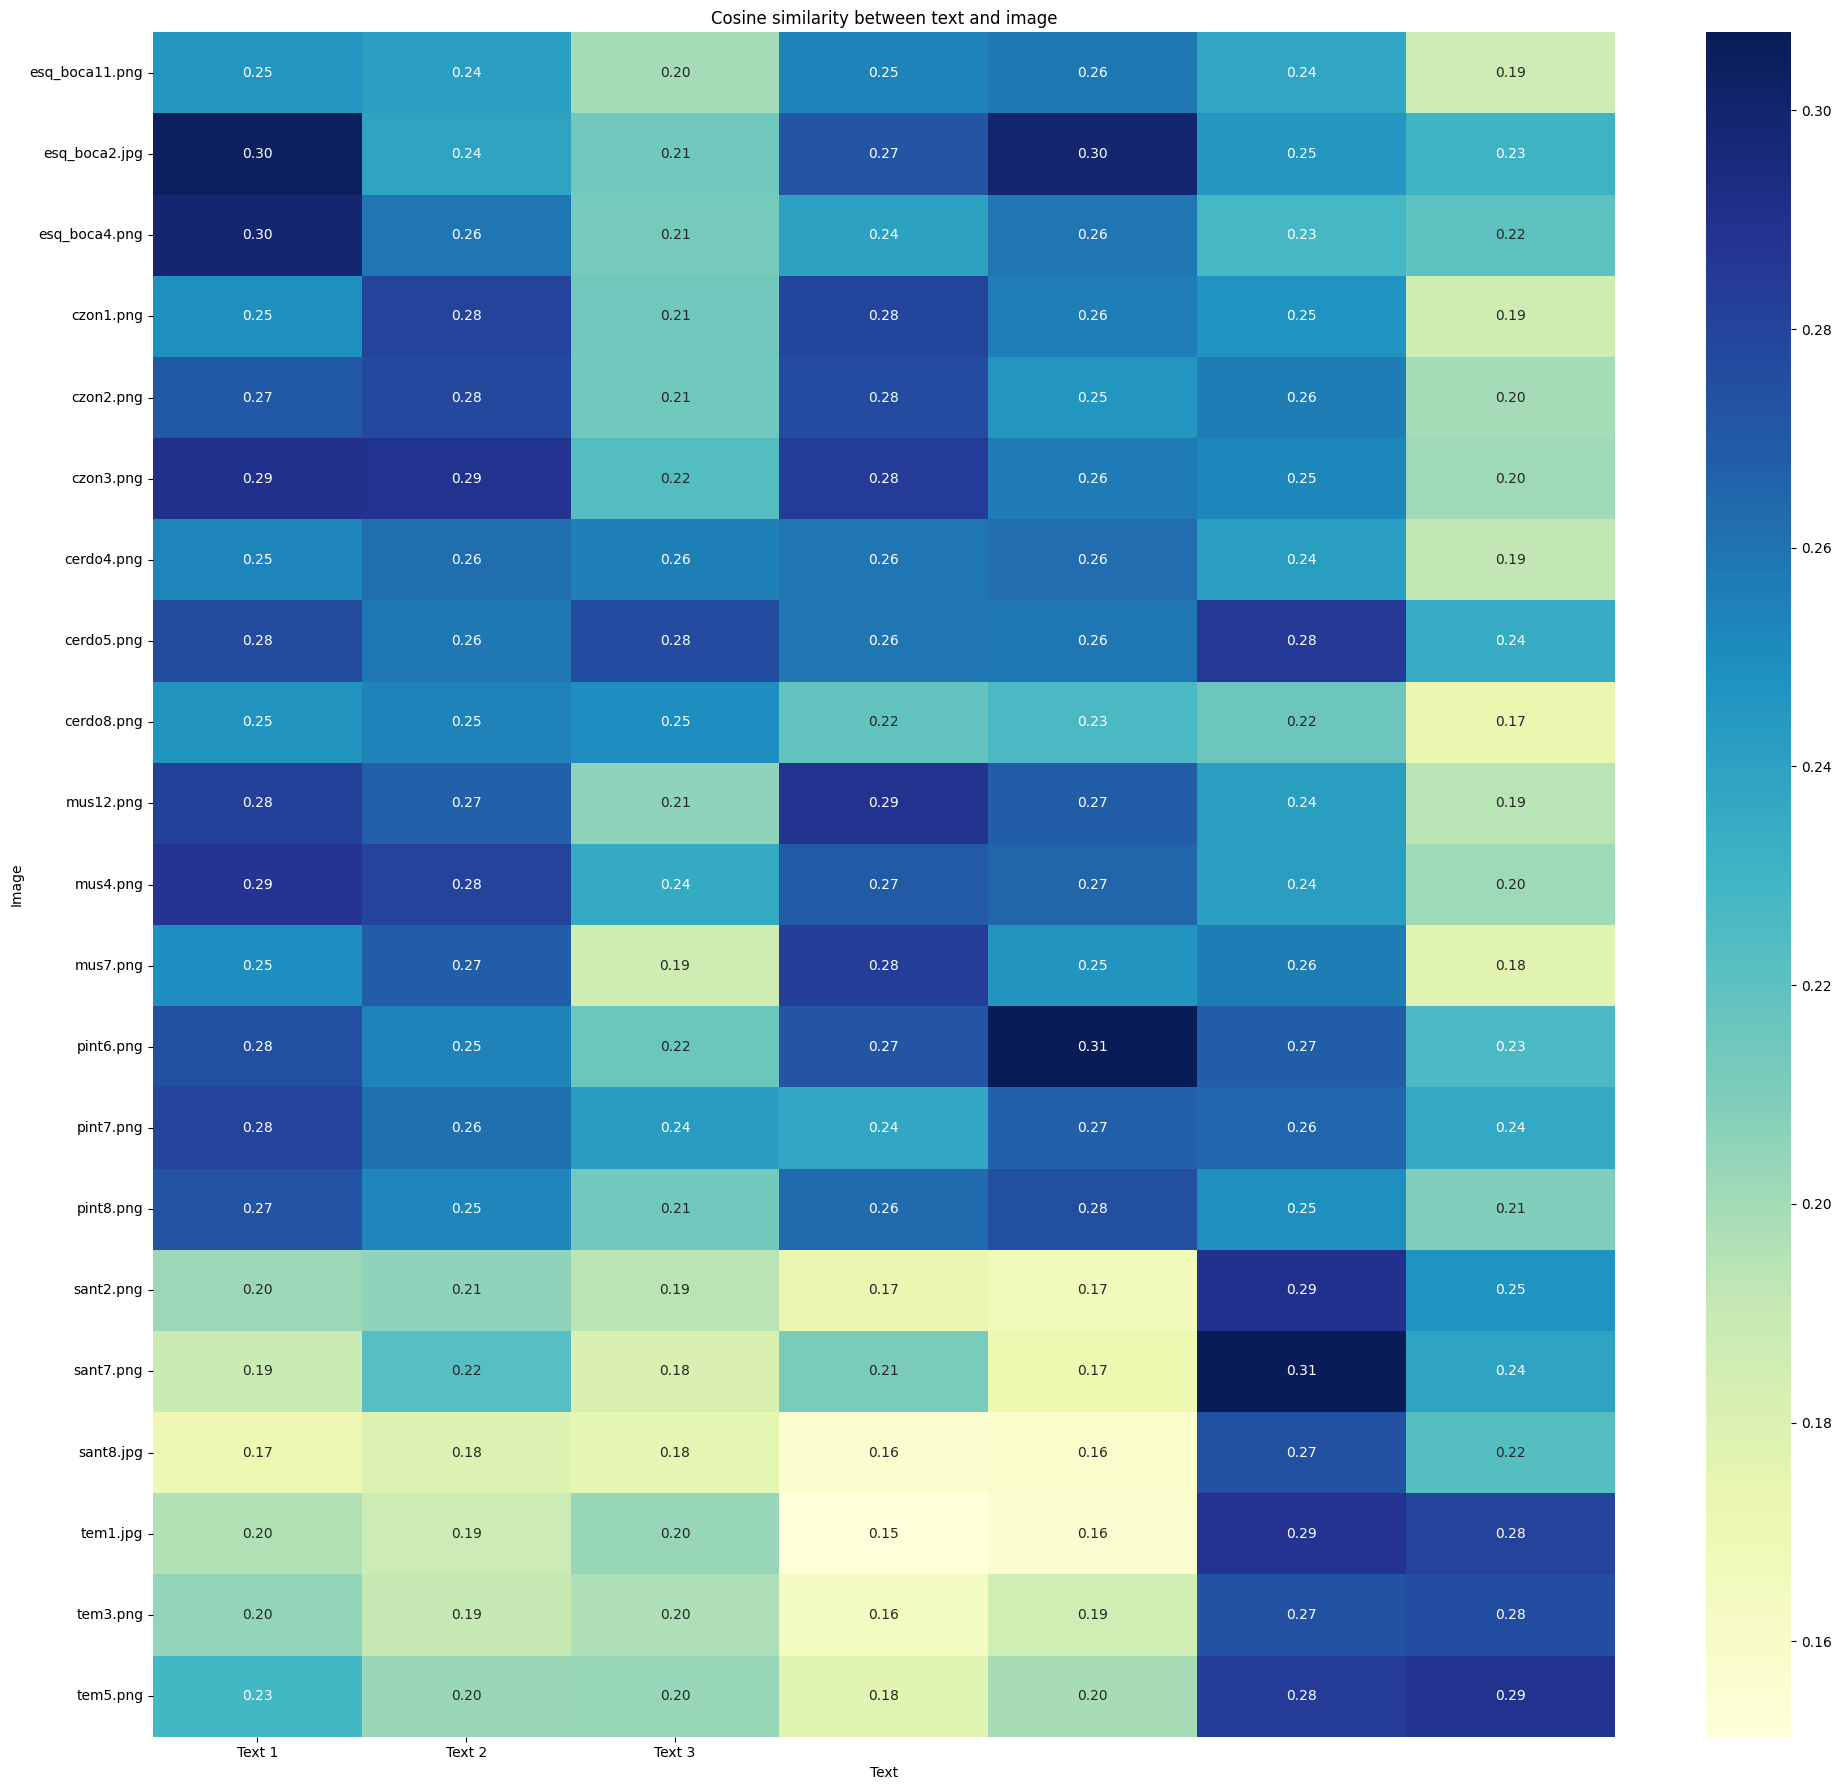

In [19]:
flat_list = []
labels = []

for species, descriptions in prompts_dict.items():
    flat_list.extend(descriptions)
    labels.extend([species] * len(descriptions))

text_inputs = torch.cat([clip.tokenize(desc) for desc in flat_list]).to(device)

with torch.no_grad():
    feature_text = model.encode_text(text_inputs)
feature_text /= feature_text.norm(dim=-1, keepdim=True)
emb_tex = feature_text.to('cpu').to(torch.float32)

with torch.no_grad():
    feature_image = model.encode_image(batch_images)[:, 0, :]
feature_image /= feature_image.norm(dim=-1, keepdim=True)
emb_img = feature_image.to('cpu').to(torch.float32)

similarity_matrix = emb_img @ emb_tex.T

plt.figure(figsize=(20, 18))
sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap='YlGnBu',
            xticklabels=["Text 1", "Text 2", "Text 3"],
            yticklabels=nombres_archivos)
plt.title("Cosine similarity between text and image")
plt.xlabel("Text")
plt.ylabel("Image")
plt.tight_layout()
plt.show()


# TEST

In [20]:
classes_description = df.values.tolist()
labels = to_select

In [21]:

main_folder = r'D:\datasets\ELASMOBRANC\data'

image_paths_shark = []
labels_shark = []

for class_name in os.listdir(main_folder):
    if any(excl in class_name.lower() for excl in exclude_classes):
        continue  # salta a la siguiente clase
    class_folder = os.path.join(main_folder, class_name)
    if os.path.isdir(class_folder):
        for item_name in os.listdir(class_folder):
            item_path = os.path.join(class_folder, item_name)
            if os.path.isfile(item_path):
                image_paths_shark.append(item_path)
                labels_shark.append(class_name)


classes_description = [
    [desc for desc in prompts_dict[especie]]
    for especie in to_select
]

In [22]:
labels_shark
labels_shark = [label.lower() for label in labels_shark]
labels_shark = [name_to_family[name] for name in labels_shark]

In [23]:
results=[]
final_label = []   

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-L/14', device)

imagens_tensor = []
for r in image_paths_shark:
    image = Image.open(r)
    image = resize_con_padding(image)  
    image_input = preprocess(image).unsqueeze(0).to(device)
    imagens_tensor.append(image_input)

text_description = []
for species in classes_description:
    for name in species:
        text_description.append(name)
        
text_inputs = torch.cat([clip.tokenize( c) for c in text_description]).to(device)

with torch.no_grad():
  feature_text = model.encode_text(text_inputs)
feature_text /= feature_text.norm(dim=-1, keepdim=True)

batch_images = torch.cat(imagens_tensor, dim=0)
with torch.no_grad():
  feature_image = model.encode_image(batch_images)[:,0,:]

  
block_sizes = [len(group) for group in classes_description] 
block_limits = []
cumulative = 0
for size in block_sizes:
    block_limits.append((cumulative, cumulative + size - 1))
    cumulative += size
                                             
for img in feature_image:
  img_norm = img / img.norm(dim=-1, keepdim=True)

  similarity = torch.stack([100.0 * img_norm @ feature_text[b[0]:b[1]+1].T.mean(dim=-1) for b in block_limits])

  similarity=similarity.softmax(dim=-1)
  
  value, indice = similarity.topk(1)
  results.append([indice.tolist()[0],value.tolist()[0]])
  final_label.append(labels[indice.tolist()[0]])


Accuracy balanced: 0.5086
Accuracy: 0.5022

Classification Report:
               precision    recall  f1-score   support

   bocanegra       0.24      0.57      0.34        37
       cazon       0.27      0.42      0.33        38
cerdo_marino       0.68      0.42      0.52        36
      musola       0.40      0.61      0.48        76
  pintarroja       0.95      0.17      0.28       121
 santiaguesa       0.70      0.94      0.80        90
  tembladera       0.96      0.44      0.60        50

    accuracy                           0.50       448
   macro avg       0.60      0.51      0.48       448
weighted avg       0.67      0.50      0.48       448



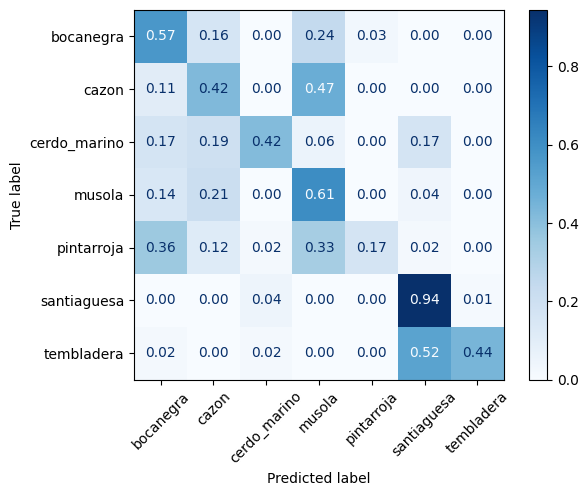

In [24]:
acc = balanced_accuracy_score(labels_shark, final_label)
print(f"Accuracy balanced: {acc:.4f}")
acc = accuracy_score(labels_shark, final_label)
print(f"Accuracy: {acc:.4f}")

report = classification_report(labels_shark, final_label, labels=to_select, zero_division=0)
print("\nClassification Report:\n", report)

cm = confusion_matrix(labels_shark, final_label, labels=to_select, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=to_select)
disp.plot(cmap='Blues', xticks_rotation=45, values_format=".2f")  
plt.show()


In [25]:
from sklearn.metrics import classification_report
import pandas as pd

report_dict = classification_report(
    labels_shark,
    final_label,
    labels=labels,
    zero_division=0,
    output_dict=True
)

class_accuracies = {
    label: metrics["recall"]  
    for label, metrics in report_dict.items()
    if label in labels
}

print("\nAccuracy por clase:")
for label, acc in class_accuracies.items():
    print(f"{label}: {acc:.4f}")



Accuracy por clase:
bocanegra: 0.5676
cazon: 0.4211
cerdo_marino: 0.4167
musola: 0.6053
pintarroja: 0.1653
santiaguesa: 0.9444
tembladera: 0.4400
